<a href="https://colab.research.google.com/github/jafar-albadarneh/tensorflow2-models/blob/master/Linear_regression_with_tensorflow2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q sklearn 
%tensorflow_version 2.x

In [0]:
#Imports
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib #Utility for python v2/v3 compatibilty

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

In [85]:
#Load dataset
def load_dataset():
  pd.set_option('max_columns', None) #display all columns when invoking df.head()
  pd.reset_option('max_columns') # reset df col display settings
  df_train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
  df_eval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
  y_train = df_train.pop('survived')
  y_eval = df_eval.pop('survived')
  return (df_train, df_eval, y_train, y_eval)
df_train, df_eval, y_train, y_eval = load_dataset()
print(df_train.loc[0])

sex                          male
age                            22
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object


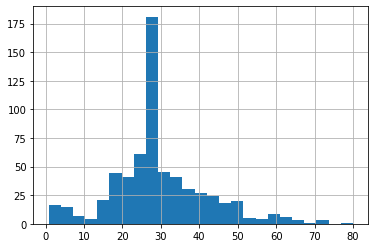

In [62]:
#Dataset statistics
df_train.age.hist(bins=25)

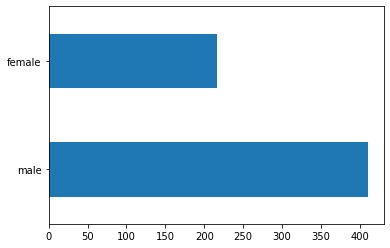

In [63]:
df_train.sex.value_counts().plot(kind='barh')

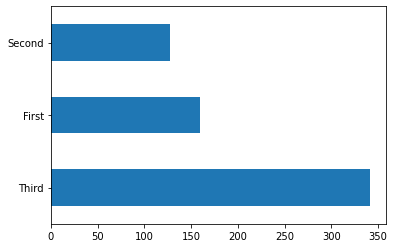

In [64]:
df_train["class"].value_counts().plot(kind='barh')

Text(0.5, 0, 'survival percentage')

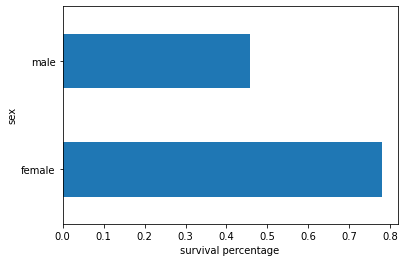

In [65]:
all = pd.concat([df_train, y_train], axis=1)
all.groupby('class').survived.mean().plot(kind='barh').set_xlabel('survival percentage')
all.groupby('sex').survived.mean().plot(kind='barh').set_xlabel('survival percentage')

In [0]:
# Data pre-processing
"""
We need to extract feature columns from thed data set 
"""
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']
def get_feature_columns():
  feature_columns = []
  for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = df_train[feature_name].unique() # get list of unique values from the dataset
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary_list=vocabulary))

  for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))
    return feature_columns

feature_columns = get_feature_columns()

In [0]:
# Training the model
def prepare_input_function(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function(): # inner function that will be returned
    dataset = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) # create a tf.Dataset object with data and labels
    if shuffle:
      dataset = dataset.shuffle(1000)
    # apply batch-sizing
    dataset = dataset.batch(batch_size).repeat(num_epochs) # split the data into batches of 32 and repeat the process by the num_epochs
    return dataset
  return input_function

# load input functions
train_input_func = prepare_input_function(df_train, y_train)
eval_input_func = prepare_input_function(df_eval, y_eval, num_epochs=1, shuffle=False)
# Creating the model
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
clear_output() # clear console output


In [92]:
# Train the model
linear_est.train(train_input_func)
result = linear_est.evaluate(eval_input_func) # get model metrics by evaluating on test dataset

clear_output() # clear console output
print(result['accuracy'])


0.77272725


In [0]:
# Model inference on the eval dataset it self
result = list(linear_est.predict(eval_input_func))
clear_output() # clear console output

In [104]:
# analyzing the predection
print(df_eval.loc[101])
print(y_eval.loc[101])
print(result[101]['probabilities'][1])

sex                        male
age                          25
n_siblings_spouses            1
parch                         0
fare                    55.4417
class                     First
deck                          E
embark_town           Cherbourg
alone                         n
Name: 101, dtype: object
1
0.7685573


#Model Optimization
Try to remove the attribute `n_siblings_spouses` and see how it does affect the accuracy


In [105]:
# Fine tuning the model
"""
Drop `n_siblings_spouses`
"""
CATEGORICAL_COLUMNS = ['sex','parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']
df_train.pop('n_siblings_spouses')
df_eval.pop('n_siblings_spouses')
feature_columns = get_feature_columns()
# Creating the model
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
clear_output() # clear console output
# re-evaluate the model
linear_est.train(train_input_func)
result2 = linear_est.evaluate(eval_input_func)
clear_output()
print(result2['accuracy'])
df_train, df_eval, y_train, y_eval = load_dataset()

0.7537879
